# 피마 인디언 당뇨병 데이터

## 데이터 전처리

In [1]:
import pandas as pd

df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
df.Outcome.value_counts() # False/True의 이진분류

0    500
1    268
Name: Outcome, dtype: int64

In [4]:
df.duplicated().sum() # 중복된 데이터는 없음

0

In [5]:
# 이상치 확인
for column in df.columns.to_list():
  print(column, len(df[df[column] == 0]))

Pregnancies 111
Glucose 5
BloodPressure 35
SkinThickness 227
Insulin 374
BMI 11
DiabetesPedigreeFunction 0
Age 0
Outcome 500


Pregnancies, SkinThickness, Insulin, BMI에 대해서 0인 값은 이상치로 볼 수 있지 않을까?

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop("Outcome", axis=1), df.Outcome, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(614, 8) (614,)
(154, 8) (154,)


In [7]:
# 이상치 처리-이상치에 평균 적용
import numpy as np
cols =['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

def impute_zero(data,col):
  df=data.loc[data[col] !=0 , col]    # 0이 아닌 부분들을 추출해서
  avg=np.sum(df)/len(df)              # 추출된 부분의 평균을 구해서
  k=len(data.loc[data[col]==0, col])
  data.loc[data[col] ==0, col] = avg  # 0인 값들을 평균으로 대체
  print('%s : fixed %d, mean: %.3f' %(col,k,avg))

for col in cols:
  impute_zero(X_train, col)

Glucose : fixed 5, mean: 121.847
BloodPressure : fixed 24, mean: 72.239
SkinThickness : fixed 176, mean: 28.596
Insulin : fixed 290, mean: 154.330
BMI : fixed 7, mean: 32.352


In [8]:
# 테스트 데이터 이상치 처리

for col in cols:
  impute_zero(X_test, col)

Glucose : fixed 0, mean: 121.052
BloodPressure : fixed 11, mean: 73.091
SkinThickness : fixed 51, mean: 31.524
Insulin : fixed 84, mean: 161.186
BMI : fixed 4, mean: 32.883


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

y_train_s = y_train.values
y_test_s = y_test.values

## Build Model

In [101]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
  model = keras.Sequential()
  model.add(layers.Dense(12, input_dim=8, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(8, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation='sigmoid')) # 이진 분류이기 때문에 0~1의 값으로 나오는 sigmoid를 활성화 함수로 사용
  return model

In [102]:
model = build_model()
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 12)                108       
                                                                 
 dropout_27 (Dropout)        (None, 12)                0         
                                                                 
 dense_54 (Dense)            (None, 8)                 104       
                                                                 
 dropout_28 (Dropout)        (None, 8)                 0         
                                                                 
 dense_55 (Dense)            (None, 1)                 9         
                                                                 
Total params: 221 (884.00 Byte)
Trainable params: 221 (884.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [103]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

In [104]:
# 모델의 학습
history = model.fit(X_train_s, y_train_s, epochs=500, batch_size=16, validation_split=0.2, verbose=1)
# verbose는 모델의 훈련 과정 중 출력되는 정보의 양을 조절
# verbose=0: 훈련 동안 아무런 출력을 하지 않음
# verbose=1: 훈련 진행 상황을 나타내는 진행 막대와 함께 출력
# verbose=2: 각 에포크마다 한 줄씩 출력

Epoch 1/500
31/31 [==============================] - 1s 10ms/step - loss: 0.8850 - acc: 0.4929 - val_loss: 0.8240 - val_acc: 0.3496
Epoch 2/500
31/31 [==============================] - 0s 4ms/step - loss: 0.8275 - acc: 0.5418 - val_loss: 0.7799 - val_acc: 0.4309
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 0.7786 - acc: 0.5580 - val_loss: 0.7425 - val_acc: 0.4959
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 0.7342 - acc: 0.5784 - val_loss: 0.7174 - val_acc: 0.5691
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 0.7072 - acc: 0.5947 - val_loss: 0.6972 - val_acc: 0.6016
Epoch 6/500
31/31 [==============================] - 0s 7ms/step - loss: 0.7046 - acc: 0.6232 - val_loss: 0.6842 - val_acc: 0.6098
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 0.6936 - acc: 0.6497 - val_loss: 0.6719 - val_acc: 0.6098
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 0.6756 - 

In [105]:
# 학습곡선 그리기

import matplotlib.pyplot as plt

def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch

  plt.figure(figsize=(16,8))
  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'],hist['loss'],label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'],label='Val Loss')

  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'],hist['acc'],label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_acc'],label='Val Accuracy')
  plt.legend()

  plt.show()

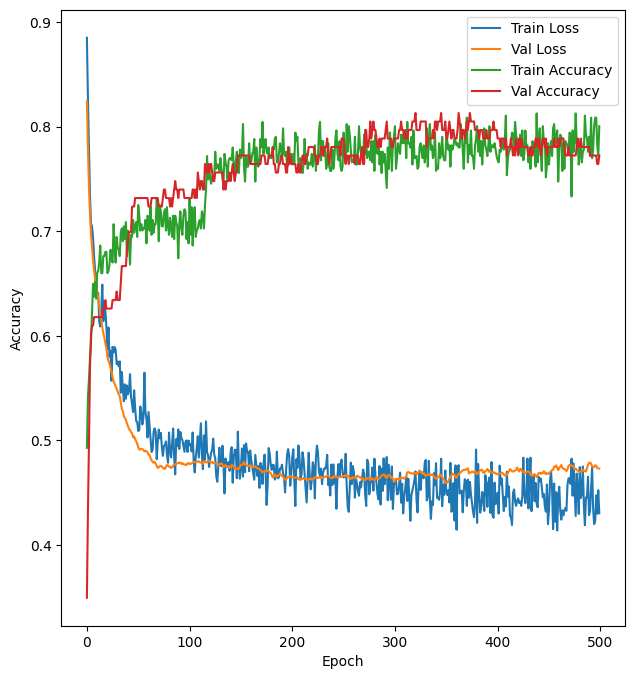

In [106]:
plot_history(history)

In [109]:
pd.DataFrame(history.history).tail()

,loss,acc,val_loss,val_acc
495,0.423244,0.808554,0.476186,0.772358
496,0.447504,0.808554,0.475889,0.772358
497,0.429871,0.782077,0.473506,0.764228
498,0.452338,0.771894,0.473279,0.764228
499,0.430341,0.800407,0.473062,0.772358


In [110]:
pd.DataFrame(history.epoch).tail()

,0
495,495
496,496
497,497
498,498
499,499
